In [2]:
from gensim.models import fasttext
from gensim.models import FastText
import pandas as pd
from nltk.tokenize import RegexpTokenizer
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

origin_train = './train_data/'
origin_test = './test_data/'

In [3]:
corpus = pd.read_csv(origin_train + 'corpus.csv')
corpus

,quechua
0,Quchakuna: Kivu qucha
1,Runakunaqa uywakunapas ñawinkunawanmi rikun. R...
2,Commons nisqaqa multimidya kapuyninkunayuqmi k...
3,NaN
4,Commons nisqaqa multimidya kapuyninkunayuqmi k...
...,...
178960,"Ellos son hechiceros, ch'eqmiseros228, brujos229."
178961,6 ñiqin hatun puquy killapi 337 watapimanta 12...
178962,Kuyuylla karu rimanapaq rikuriy
178963,Haki distritu (kastilla simipi: Distrito de Ja...


In [4]:
sufixes = pd.read_csv(origin_train + 'sufixes.csv')
sufixes

,sufix
0,cha
1,chaw
2,chi
3,chka
4,chra
...,...
69,yoq
70,ysi
71,yuq
72,ña


## Preprocesamiento

In [5]:
def remove_sufixes(word,sufixes):
  for suffix in sufixes:
    if word.endswith(suffix):
      return word[:-len(suffix)]
  return word

def remove_empty_strings_rows(df):
  return df[df['quechua'].str.strip().astype(bool)]

def remove_invalid_word(word):
    # Check if the word contains any digits
    if re.search(r'\d', word):
        return ''
    
    # Check if the word contains only allowed characters (a-z, ñ, apostrophes, and spaces)
    if not re.match(r"^[a-zñA-ZÑ' ]*$", word):
        return ''
    
    # Check if the word contains any of the unwanted characters: b, d, e, f, g, j, o, v, x, z
    if re.search(r"[bdefgjovxzBDEFGJOVXZ]", word):
        return ''
    
    return word

def clean_df(cad):
    text = cad.lower()
    text = " ".join(text.split())
    text = text.replace('´',"'")
    
    tokenizer = RegexpTokenizer(r"[a-zA-Z0-9']+(?:\w*)")
    text = tokenizer.tokenize(text)
    words = [remove_sufixes(word,sufixes['sufix']) for word in text]
    words = [remove_invalid_word(word) for word in words]
    result = " ".join(words)
    result = ' '.join(result.split())
    return result.split()

In [6]:
corpus['quechua'] = remove_empty_strings_rows(corpus)['quechua']
corpus.dropna(inplace=True)
corpus['quechua'] = corpus['quechua'].apply(clean_df)
corpus = corpus[corpus['quechua'].apply(lambda x: len(x) > 0)]
corpus['quechua'] = corpus['quechua'].apply(lambda list: [word for word in list if len(word) >= 3])

/tmp/ipykernel_43475/5957910.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus['quechua'] = corpus['quechua'].apply(lambda list: [word for word in list if len(word) >= 3])


In [7]:
corpus

,quechua
0,[qucha]
1,"[runakuna, uywakuna, awinkunawan, riku, runa, ..."
2,"[nisqa, kapuyninkunayuq, hawa, iqi, pachakwa]"
4,"[nisqa, kapuyninkunayuq, hawa]"
5,"[killawat'a, quwati, nisqa, kasti, simi, isla,..."
...,...
178958,"[llaqtapi, runakuna, kawsachkan]"
178959,"[llaq, piruw]"
178961,"[iqi, hatu, puqu, killa, watapi, iqi, ayriwa, ..."
178962,"[kuyuy, karu, rimana, rikuri]"


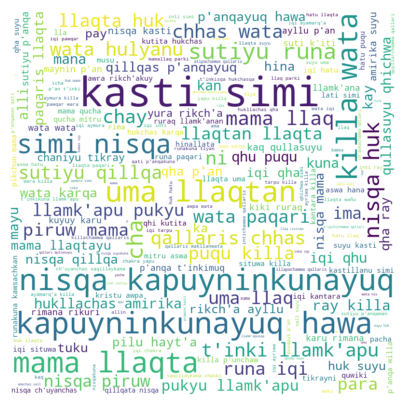

In [8]:
wordcloud = WordCloud(width = 800, height = 800,background_color="white").generate(corpus['quechua'].apply(lambda x: ' '.join(x)).to_string())
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
!curl -o ./train_data/cc.qu.300.bin.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.qu.300.bin.gz
!tar -xvf ./train_data/cc.qu.300.bin.gz

In [9]:

modelFT = fasttext.load_facebook_model(origin_train+'cc.qu.300.bin')

In [10]:
modelFT.build_vocab(corpus['quechua'], update=True)

In [11]:
modelFT.train(corpus['quechua'], total_examples=modelFT.corpus_count, epochs=15)

(3153705, 13357335)

In [6]:
modelFT.save(origin_train+'fasttext.model')

In [12]:
modelFT.wv.most_similar_to_given('wayra',['runa','pisqu','suyo'])

'pisqu'

In [37]:
#modelFT = FastText.load(origin_train+'fasttext.model')

## Tests

In [13]:

sentiment_df = pd.read_csv(origin_test+'QuechuaCollaoCorpus.csv')
sentiment_df.dropna(inplace=True)
sentiment_df

,ID,N°,Tipo,T,Quechua,Traducción,Sentimiento
0,B001,1,Palabra,W,Ch’arwi,Desorden,ABURRIDO
1,B002,2,Palabra,W,Runa,Persona,ABURRIDO
2,B003,3,Palabra,W,Chanin,Precio,ABURRIDO
3,B004,4,Palabra,W,Puka,Rojo,ABURRIDO
4,B005,5,Palabra,W,Hallp’a,Tierra,ABURRIDO
...,...,...,...,...,...,...,...
2066,T226,226,Oración,S,Runakuna manan mallkikunata tarpunkuchu chaymi...,La personas no plantan árboles es uno de los f...,TRISTE
2067,T227,227,Oración,S,Erqe mamanpa wañusqanmanta waqan.,El niño llora porque su madre murió.,TRISTE
2068,T228,228,Oración,S,Huk wayna chakamanta wukchuyukusqa hinaspa wañ...,Un joven se lanzó del puente y murió.,TRISTE
2069,T229,229,Oración,S,Mama churin mana wasinman kutimusqanmanta waqan.,La madre llora porque su hijo no vuelve a la c...,TRISTE


In [14]:

dict_sentiment ={value: key for key,value in enumerate(set(sentiment_df['Sentimiento']))}
dict_sentiment

{'TEMEROSO': 0,
 'EMOCIONADO': 1,
 'NEUTRAL': 2,
 'CALMADO': 3,
 'FELIZ': 4,
 'ABURRIDO': 5,
 'ENOJADO': 6,
 'TRISTE': 7,
 'ADORMILADO': 8}

In [15]:
def group_sentiment(sentiment:str)->int:
    postive = ['EMOCIONADO','FELIZ','CALMADO']
    neutral = ['NEUTRAL','ABURRIDO','ADORMILADO']
    negative = ['TRISTE','ENOJADO','TEMEROSO']
    
    if sentiment in postive:
        return 2
    elif sentiment in neutral:
        return 1
    elif sentiment in negative:
        return 0
    else:
        raise ValueError('Sentiment not found')
        

In [16]:
sentiment_df['Label'] = sentiment_df['Sentimiento'].apply(group_sentiment)
sentiment_df

,ID,N°,Tipo,T,Quechua,Traducción,Sentimiento,Label
0,B001,1,Palabra,W,Ch’arwi,Desorden,ABURRIDO,1
1,B002,2,Palabra,W,Runa,Persona,ABURRIDO,1
2,B003,3,Palabra,W,Chanin,Precio,ABURRIDO,1
3,B004,4,Palabra,W,Puka,Rojo,ABURRIDO,1
4,B005,5,Palabra,W,Hallp’a,Tierra,ABURRIDO,1
...,...,...,...,...,...,...,...,...
2066,T226,226,Oración,S,Runakuna manan mallkikunata tarpunkuchu chaymi...,La personas no plantan árboles es uno de los f...,TRISTE,0
2067,T227,227,Oración,S,Erqe mamanpa wañusqanmanta waqan.,El niño llora porque su madre murió.,TRISTE,0
2068,T228,228,Oración,S,Huk wayna chakamanta wukchuyukusqa hinaspa wañ...,Un joven se lanzó del puente y murió.,TRISTE,0
2069,T229,229,Oración,S,Mama churin mana wasinman kutimusqanmanta waqan.,La madre llora porque su hijo no vuelve a la c...,TRISTE,0


In [18]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.utils.rnn import pad_sequence

In [19]:
X_train, X_test, y_train, y_test = train_test_split(sentiment_df['Quechua'], sentiment_df['Label'], test_size=0.2, random_state=42,stratify=sentiment_df['Label'])

In [20]:
y_train

1046    0
1642    0
588     2
1974    0
1023    0
       ..
1320    2
892     2
576     2
792     2
1617    0
Name: Label, Length: 1654, dtype: int64

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
#RNN

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.softmax(out)
        return out
    

In [23]:

model = RNN(input_size=300, hidden_size=128, num_layers=15, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

class QuechuaDataset(Dataset):
    def __init__(self, X, y,modelFT):
        self.X = X
        self.y = y
        self.modelFT = modelFT
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        words = self.X.iloc[idx].split()
        embeddings = [self.modelFT.wv[word] for word in words if word in modelFT.wv]
        return torch.tensor(embeddings), torch.tensor(self.y.iloc[idx])

In [24]:
def collate_fn(batch):
    inputs, targets = zip(*batch)
    inputs_paddded = pad_sequence(inputs, batch_first=True)
    return inputs_paddded, torch.stack(targets)

In [26]:

train_dataset = QuechuaDataset(X_train, y_train,modelFT)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,collate_fn=collate_fn)

num_epochs = 1000

for epoch in range(num_epochs):
  for i, (data, labels) in enumerate(train_loader):
    embeddings = data.to(device)
    labels = labels.to(device)
    
    outputs = model(embeddings)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (i+1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_loader)}, Loss: {loss.item()}')
  accu = 0
  for i, (data, labels) in enumerate(train_loader):
    embeddings = data.to(device)
    labels = labels.to(device)
    outputs = model(embeddings)
    accu += (outputs.argmax(dim=1) == labels).float().mean()
  
  print(f'Epoch {epoch+1}/{num_epochs}, Accuracy: {accu/len(train_loader)}') 
   
print('Finished Training')

Epoch 1/1000, Step 5/52, Loss: 1.1465636491775513
Epoch 1/1000, Step 10/52, Loss: 1.0977377891540527
Epoch 1/1000, Step 15/52, Loss: 1.0947108268737793
Epoch 1/1000, Step 20/52, Loss: 1.0422755479812622
Epoch 1/1000, Step 25/52, Loss: 1.165238857269287
Epoch 1/1000, Step 30/52, Loss: 1.1003596782684326
Epoch 1/1000, Step 35/52, Loss: 1.138441562652588
Epoch 1/1000, Step 40/52, Loss: 1.1016279458999634
Epoch 1/1000, Step 45/52, Loss: 1.0954769849777222
Epoch 1/1000, Step 50/52, Loss: 1.1140888929367065
Epoch 1/1000, Accuracy: 0.3316214978694916
Epoch 2/1000, Step 5/52, Loss: 1.0855193138122559
Epoch 2/1000, Step 10/52, Loss: 1.0669325590133667
Epoch 2/1000, Step 15/52, Loss: 1.1342202425003052
Epoch 2/1000, Step 20/52, Loss: 1.1006132364273071
Epoch 2/1000, Step 25/52, Loss: 1.1494389772415161
Epoch 2/1000, Step 30/52, Loss: 1.1460775136947632
Epoch 2/1000, Step 35/52, Loss: 1.1447972059249878
Epoch 2/1000, Step 40/52, Loss: 1.04148268699646
Epoch 2/1000, Step 45/52, Loss: 1.09096145629

KeyboardInterrupt: 

In [97]:
embedd

tensor([[[-0.5546, -0.6703,  0.5896,  ...,  0.6004,  1.0422,  0.8633],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.3420, -0.5168,  0.7767,  ...,  0.5522,  0.1957,  0.0976],
         [-0.0774, -0.1131,  0.1986,  ...,  0.1147,  0.0482,  0.0152],
         [-0.2579, -0.3368,  0.5097,  ...,  0.3960,  0.1304,  0.0404],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.1292, -0.3385,  0.3227,  ...,  0.2582,  0.0917,  0.0406],
         [-0.1958, -0.3364,  0.4285,  ...,  0